In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
import random
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [2]:
# Read the dataset
with open("dataset_training.json") as file:
  dataset = json.load(file)
with open("dataset_validation.json") as file:
  val_dataset = json.load(file)

In [3]:
# Declare preprocessing text and dataset function
blacklist_word = ['saya']
replace_words = [
    ['wawancara', ['interview']],
    ['online', ['daring', 'remote']],
    ['meeting', ['gmeet', 'zoom']],
    ['persiapan',['persiapkan', 'disiapkan','dipersiapkan']],
    ['cv', ['curiculum vitae', 'resume']],
    ['penutup', ['closing statement']],
    ['mereschedule', ['jadwal ulang', 'menjadwalkan ulang', 'mengubah jadwal', 'merubah jadwal', 'pindah jadwal']],
    ['pewawancara', ['hrd', 'recruiter', 'interviewer', 'hr']],
    ['bagus', ['menarik', 'keren', 'tepat']],
    ['kesalahan umum', ['kesalahan kecil']],
    ['pakaian', ['baju', 'setelan', 'kostum', 'berpenampilan']],
    ['stres', ['stress']],
    ['bahasa tubuh', ['gestur', 'gerak tubuh', 'postur']],
    ['kurang', ['minim']],
    ['gugup', ['terbatabata', 'gagap', 'grogi']],
    ['saat', ['dalam proses']],
    ['pekerjaan', ['job']],
    ['hai', ['hello', 'hy', 'helo', 'halo', 'hay', 'p']]
]

def preprocessing_text(sentence):
    filtered_words = re.sub(r'[^\w\d\s]', '', sentence.lower())
    words = word_tokenize(filtered_words)

    cleaned_words = []
    for word in words:
        if word in blacklist_word: continue
        replaced = False
        for replacement, target in replace_words:
            if word in target:
                cleaned_words.append(replacement)
                replaced = True
        if not replaced:
            cleaned_words.append(word)

    return ' '.join(cleaned_words)

def processing_json_dataset(dataset):
    tags = []
    inputs = []
    responses={}
    for intent in dataset:
        responses[intent['tag']]=intent['responses']
        for lines in intent['patterns']:
            inputs.append(preprocessing_text(lines))
            tags.append(intent['tag'])
    return [tags, inputs, responses]

def processing_json_val_dataset(dataset):
    tags = []
    inputs = []
    for intent in dataset:
        for lines in intent['patterns']:
            inputs.append(preprocessing_text(lines))
            tags.append(intent['tag'])
    return [tags, inputs]

In [4]:
# Split dataset
[tags, inputs, responses] = processing_json_dataset(dataset)
[val_tags, val_inputs] = processing_json_val_dataset(val_dataset)

In [5]:
# Import tokenizer from word dictionary
tokenizer = Tokenizer(oov_token='<OOV>')
dictionaryToLoad = [
    'word_dict/kaskus.json',
    'word_dict/kompas.json'
]
for dictionary in dictionaryToLoad:
    with open(dictionary, 'r') as file:
        loadedJson = json.load(file).keys()
    tokenizer.fit_on_texts(loadedJson)
word_index = tokenizer.word_index
print(len(word_index))

15308


In [6]:
# Grouping dataset
groupedData = []
for i in range(len(tags)):
    groupedData.append([tags[i], inputs[i], responses[tags[i]]])

val_groupedData = []
for i in range(len(val_tags)):
    val_groupedData.append([val_tags[i], val_inputs[i]])

In [7]:
# Shuffle dataset for better training
random.shuffle(groupedData)
random.shuffle(val_groupedData)

In [8]:
# Resplitting the dataset
train_label = [item[0] for item in groupedData]
train_input = [item[1] for item in groupedData]
val_label = [item[0] for item in val_groupedData]
val_input = [item[1] for item in val_groupedData]

In [9]:
trunc_type = 'pre'
padding_type = 'post'
max_length = 10

tokenizer.fit_on_texts(train_input)
tokenizer.fit_on_texts(val_input)
training_sequences = tokenizer.texts_to_sequences(train_input)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_sequences = tokenizer.texts_to_sequences(val_input)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

le = LabelEncoder()
training_labels = le.fit_transform(train_label)
validation_labels = le.fit_transform(val_label)

In [10]:
# Saving tokenizer dictionary data into json
word_dict = {item[0]: item[1] for item in tokenizer.word_index.items()}
with open('tokenizer_dict_chatbot.json', 'w') as json_file:
    json.dump(word_dict, json_file, indent=4)

In [11]:
# Saving dataset labels into json
leDecoder = LabelEncoder()
leDecoder.fit(train_label)
le_name_mapping = dict(zip(leDecoder.classes_, leDecoder.transform(leDecoder.classes_)))
transformed_classes = leDecoder.transform(leDecoder.classes_).tolist()
le_name_mapping = dict(zip(leDecoder.classes_, transformed_classes))
with open('result_decoder.json', 'w') as json_file:
    json.dump(le_name_mapping, json_file, indent=4)

In [12]:
print(f"Training shape: {len(training_padded[0])}")
print(training_padded.shape)
print(f"Validation shape: {len(validation_padded[0])}")
print(validation_padded.shape)

Training shape: 10
(117, 10)
Validation shape: 10
(41, 10)


In [13]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  15336
output length:  30


In [14]:
# GloVe embedding
glove_dir = "../../glove.6B/glove.6B.100d.txt"
embeddings_index = {}
file_ = open(glove_dir, encoding="utf8")
for line in file_:
    arr = line.split()
    single_word = arr[0]
    w = np.asarray(arr[1:],dtype='float32')
    embeddings_index[single_word] = w
file_.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [15]:
max_words = vocabulary + 1
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words,100)).astype(object)
for word , i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [16]:
# Declare graph function and callback class
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.ylim(bottom=0)
    plt.show()
    
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.8 and logs.get('accuracy') > 0.92:
            self.model.stop_training = True

In [17]:
# Declare the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(training_padded.shape[1])),
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=100, weights=[embedding_matrix], trainable=False, mask_zero=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GRU(128, dropout=0.2, return_sequences=True),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.GRU(128, dropout=0.1, return_sequences=False),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(output_length, activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           1533700   
                                                                 
 dropout (Dropout)           (None, 10, 100)           0         
                                                                 
 gru (GRU)                   (None, 10, 128)           88320     
                                                                 
 layer_normalization (LayerN  (None, 10, 128)          256       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 10, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                        

In [18]:
# Compile and training the model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(0.0006),
    metrics=['accuracy']
)
history = model.fit(
    training_padded,
    training_labels,
    epochs=500,
    batch_size=64,
    validation_data=(validation_padded, validation_labels),
    callbacks=[Callback()]
)

Epoch 1/500
2/2 [==============================] - 9s 2s/step - loss: 4.2190 - accuracy: 0.0256 - val_loss: 3.8308 - val_accuracy: 0.0244
Epoch 2/500
2/2 [==============================] - 0s 72ms/step - loss: 3.7427 - accuracy: 0.0598 - val_loss: 3.6249 - val_accuracy: 0.0244
Epoch 3/500
2/2 [==============================] - 0s 61ms/step - loss: 3.6322 - accuracy: 0.0855 - val_loss: 3.5149 - val_accuracy: 0.0488
Epoch 4/500
2/2 [==============================] - 0s 59ms/step - loss: 3.4684 - accuracy: 0.1111 - val_loss: 3.4785 - val_accuracy: 0.0732
Epoch 5/500
2/2 [==============================] - 0s 54ms/step - loss: 3.2498 - accuracy: 0.1368 - val_loss: 3.4325 - val_accuracy: 0.1463
Epoch 6/500
2/2 [==============================] - 0s 60ms/step - loss: 3.1524 - accuracy: 0.1197 - val_loss: 3.3445 - val_accuracy: 0.1707
Epoch 7/500
2/2 [==============================] - 0s 52ms/step - loss: 3.1060 - accuracy: 0.1624 - val_loss: 3.2331 - val_accuracy: 0.1707
Epoch 8/500
2/2 [=====

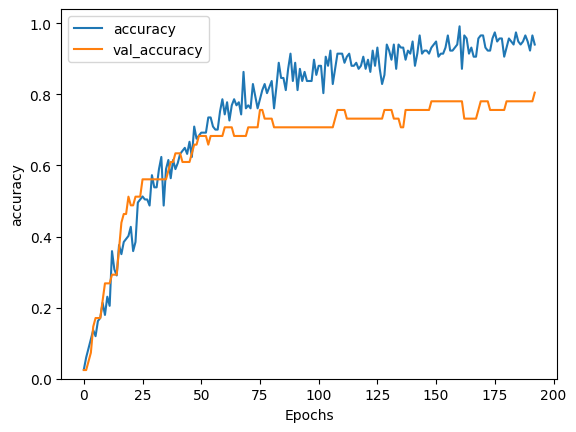

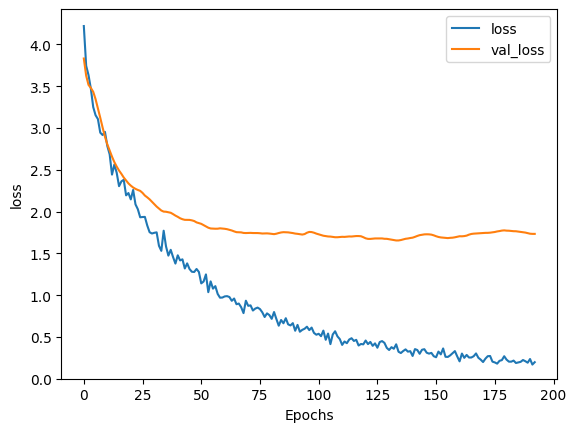

In [19]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [20]:
def generate_answer(input):
    input = preprocessing_text(input)
    input = tokenizer.texts_to_sequences([input])
    input = np.array(input).reshape(-1)
    input = pad_sequences([input], training_padded.shape[1])
    output = model.predict(input, verbose=0)
    output = output.argmax()
    response_tag = le.inverse_transform([output])[0]
    print(f'[{response_tag}]:', random.choice(responses[response_tag]))

In [21]:
generate_answer('hai')

[common_hello]: Hai, saya siap membantu. Ada yang perlu ditanyakan?


In [22]:
generate_answer('siapa kamu?')

[common_about]: Halo! Saya xx, asisten virtual dari InterviewKu. Ada pertanyaan seputar wawancara yang bisa saya bantu jawab?


In [23]:
generate_answer('tips membuat cv yang menarik')

[cv_tips]: Ketika menyusun CV, penting untuk memberikan penekanan pada keterampilan dan pengalaman yang sesuai dengan posisi yang Anda inginkan. Jelaskan secara singkat bagaimana setiap pengalaman kerja Anda dapat memberikan nilai tambah kepada perusahaan. Gunakan bahasa yang positif dan aktif, dan hindari penggunaan frasa yang terlalu umum. Selain itu, pastikan untuk mencantumkan pendidikan, sertifikasi, dan keterampilan teknis yang relevan. CV yang efektif adalah yang memberikan gambaran komprehensif tentang kualifikasi dan potensi Anda sebagai kandidat yang cocok untuk pekerjaan.


In [24]:
generate_answer('cara agar tidak gugup saat wawancara')

[interview_handling_nervous]: Atasi rasa gugup dengan melakukan latihan pernapasan dan memusatkan perhatian pada pertanyaan yang diajukan. Ingatlah bahwa gugup adalah sesuatu yang dialami banyak orang dan dapat diatasi dengan pengalaman. Tunjukkan sikap profesional dan percaya diri selama wawancara.


In [25]:
generate_answer('pakaian apa yang cocok untuk wawancara?')

[interview_appearance]: Selama wawancara, pastikan untuk memberikan penampilan yang konsisten dengan budaya perusahaan. Pakaian yang bersih dan rapi, serta rambut dan grooming yang terawat, menciptakan kesan profesional. Selain itu, berikan senyuman yang ramah dan pertahankan kontak mata yang tepat. Penampilan yang baik memberikan kesan bahwa Anda menghargai kesempatan wawancara dan serius dalam mencari pekerjaan.


In [26]:
generate_answer('cara menjawab pertanyaan yang menanyakan gaji yang diinginkan')

[salary_question]: Sebelum menjawab pertanyaan tentang gaji, lakukan riset untuk mengetahui kisaran gaji yang wajar untuk posisi tersebut. Sampaikan bahwa Anda menghargai nilai diri Anda dan ingin mendapatkan kompensasi yang sejalan dengan keterampilan dan pengalaman Anda. Bersiaplah untuk bernegosiasi dan berikan kesan bahwa Anda tahu nilai Anda sebagai seorang profesional.
